<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Ruslan-Kuzminov-folder/Ruslan-Kuzminov-folder/identification_7_week_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Идентификация по сетчатке

### **7 неделя**

**Задачи:**
- Дообучение модели на 25 новых классах


### Подключение библиотек

In [ ]:
# импортируем необходимые для работы библиотеки

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

import os

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, SpatialDropout2D, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import pytorch_lightning as pl
from sklearn.preprocessing import LabelEncoder

import cv2
#from google.colab.patches import cv2_imshow

import random
import math

import tqdm as tq

from sklearn.model_selection import train_test_split

from scipy.ndimage import gaussian_laplace
from skimage.filters import gabor
from skimage.color import rgb2gray

from pathlib import Path
from engine import train_one_epoch, evaluate
#import evaluate

/Users/ruslankuzminov/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Если директория "vision" не существует, то происходит клонирование репозитория
if not Path("vision").exists():
    # происходит клонирование репозитория "vision" из GitHub в текущую директорию. 
    !git clone https://github.com/pytorch/vision.git
    # переход в директорию "vision" 
    os.chdir("vision")
    # переключаем репозиторий на версию 0.15.2.
    !git checkout v0.15.2
    # копируем необходимые файлы из директории "references/detection" в родительскую директорию
    !cp references/detection/utils.py ../
    !cp references/detection/transforms.py ../
    !cp references/detection/coco_eval.py ../
    !cp references/detection/engine.py ../
    !cp references/detection/coco_utils.py ../
    # возврат в родительскую директорию
    os.chdir("..")

In [ ]:
# инициализируем GPU

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
x = torch.ones(1, device=device)
print (x)

tensor([1.], device='mps:0')


### Загрузка данных

In [ ]:
# проверяем содержимое папки

IMAGE_TRAIN_PATH = 'images_train' # изображения тренировочной выборки
IMAGE_VALID_PATH = 'images_valid' # изображения валидационной выборки
IMAGE_TEST_PATH = 'images_test' # изображения тестовой выборки

IMAGE_FILES_TRAIN = sorted(os.listdir(IMAGE_TRAIN_PATH))
IMAGE_FILES_VALID = sorted(os.listdir(IMAGE_VALID_PATH))
IMAGE_FILES_TEST = sorted(os.listdir(IMAGE_TEST_PATH))

print(IMAGE_FILES_TRAIN[:5])
print(IMAGE_FILES_VALID[:5])
print(IMAGE_FILES_TEST[:5])

['001L_1.png', '001R_1.png', '002L_1.png', '002R_1.png', '003L_1.png']
['001L_2.png', '001R_2.png', '002L_2.png', '002R_2.png', '003L_2.png']
['001L_3.png', '001R_3.png', '002L_3.png', '002R_3.png', '003L_3.png']


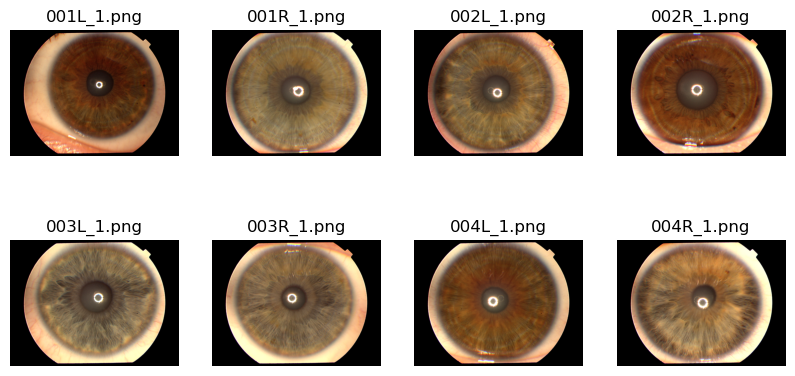

In [ ]:
# выводим серию оригинальных случайных изображений на экран

fig = plt.figure(figsize=(10,5))

for i in range(len(IMAGE_FILES_TRAIN)):
    dirs_path = f'{IMAGE_TRAIN_PATH}/'
    img_path = dirs_path + random.choice(os.listdir(dirs_path))
    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title(IMAGE_FILES_TRAIN[i])
    ax.imshow(Image.open(img_path)) # применяем функцию обрезки изображения
    ax.axis('off')
    if i == 7: # остановить добавление изображений после 8
        break

plt.show()

In [ ]:
# создаем функцию обрезки изображения

def crop_circular_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Конвертация из BGR в RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Получение размеров изображения
    height, width, _ = image.shape

    # Создание круглой маски
    mask = np.zeros((height, width), np.uint8)
    center = (width // 2, height // 2)
    radius = int(min(width, height) // 2.025)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Применение маски к изображению
    circular_image = cv2.bitwise_and(image, image, mask=mask)

    # Вычисление координат верхнего левого угла прямоугольника
    x = int((width - min(width, height)) // 2.1)
    y = int((height - min(width, height)) // 2)

    # Вырезание прямоугольной области из изображения
    cropped_image = circular_image[y:y + min(width, height), x:x + min(width, height)]

    # Получение размеров обрезанного изображения
    cropped_height, cropped_width, _ = cropped_image.shape

    # Переопределение центра и радиуса для обрезанного изображения
    center = (cropped_width // 2, cropped_height // 2)
    radius = min(cropped_width, cropped_height) // 2

    return cropped_image, center, radius

In [ ]:
# создаем функцию полярного преобразования координат

def unwrap_image(cropped_image, center, radius):
    # создаем новое изображения для результатов развертывания
    unwrapped_image = np.zeros((radius, 360, 3), dtype=np.uint8)

    # пройдем по всем пикселям в новом изображении и копируйте их из обрезанного изображения
    for r in range(radius):
        for theta in range(360):
            # преобразуем полярные координаты в декартовы
            x_unwrap = center[0] + r * np.cos(np.deg2rad(theta))
            y_unwrap = center[1] + r * np.sin(np.deg2rad(theta))

            # копируем пиксель
            unwrapped_image[r, theta] = cropped_image[int(y_unwrap), int(x_unwrap)]
            
    # обрезание изображения для получения прямоугольника в центре
    rectangle_height = int(radius // 2.5) #  сохраняем центральную треть изображения
    rectangle_start = int((radius - rectangle_height) // 2) # начало прямоугольника
    rectangle_image = unwrapped_image[rectangle_start : rectangle_start + rectangle_height, :]

    return rectangle_image

In [ ]:
# создаем фильтр Гаусса и оператор Лапласа
def apply_gaussian_laplace(image, sigma=1.2):
    # Применение фильтра Гаусса и оператора Лапласа
    filtered_image = gaussian_laplace(image, sigma)

    return filtered_image

# создаем функцию для извлечения признаков с использованием вейвлетов Габора
def apply_gabor_filter(image, frequency=0.7):
    # преобразование изображения в оттенки серого, если оно цветное
    if len(image.shape) > 2:
        image = rgb2gray(image)

    # применение фильтра Габора
    gabor_response, _ = gabor(image, frequency)

    # нормализация gabor_response в диапазон [0, 1]
    gabor_response = (gabor_response - gabor_response.min()) / (gabor_response.max() - gabor_response.min())

    # преобразование gabor_response в тип uint8
    gabor_response = (gabor_response * 255).astype(np.uint8)

    # адаптивная бинаризация изображения
    binary_gabor = cv2.adaptiveThreshold(gabor_response, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    
    return binary_gabor

In [ ]:
# cоздаем функцию, применяющую все фильтры к изображению

def process_images(directory_path):
    result = []
    
    for img_file in tq.tqdm(sorted(os.listdir(directory_path))):
        img_path = os.path.join(directory_path, img_file)

        # применяем функцию обрезки изображения
        cropped_image, center, radius = crop_circular_image(img_path)

        # "Разворачивание" обрезанного изображения
        unwrapped_image = unwrap_image(cropped_image, center, radius)

        # Применение фильтра Гаусса и оператора Лапласа
        gauss_laplace_img = apply_gaussian_laplace(unwrapped_image)

        # Извлечение признаков с использованием вейвлетов Габора
        gabor_img = apply_gabor_filter(gauss_laplace_img)

        # Получаем метку (label) из имени файла
        label = os.path.splitext(img_file)[0][:-2]

        # Сохранение результата
        result.append({
            "file_name": img_file,
            "gabor_filter": gabor_img,
            "label": label
        })
        
    return result

In [ ]:
def print_dictionary_structure(processed_images):
    # Печатаем количество элементов в списке
    print(f'Количество изображений: {len(processed_images)}')
    # Собираем все метки в список
    labels = [image['label'] for image in processed_images]
    # Выводим количество уникальных меток
    print(f'Количество меток: {len(labels)}')
    
    if processed_images:
        # Получаем первый элемент
        first_image = processed_images[0]

        # Печатаем все ключи и их типы данных
        for key, value in first_image.items():
            print(f'{key}: {type(value)}')

        # Если значение - массив numpy, выводим его форму
        if isinstance(first_image['gabor_filter'], np.ndarray):
            print('Размер изображений:', first_image['gabor_filter'].shape)
    else:
        print("List 'processed_images' is empty.")

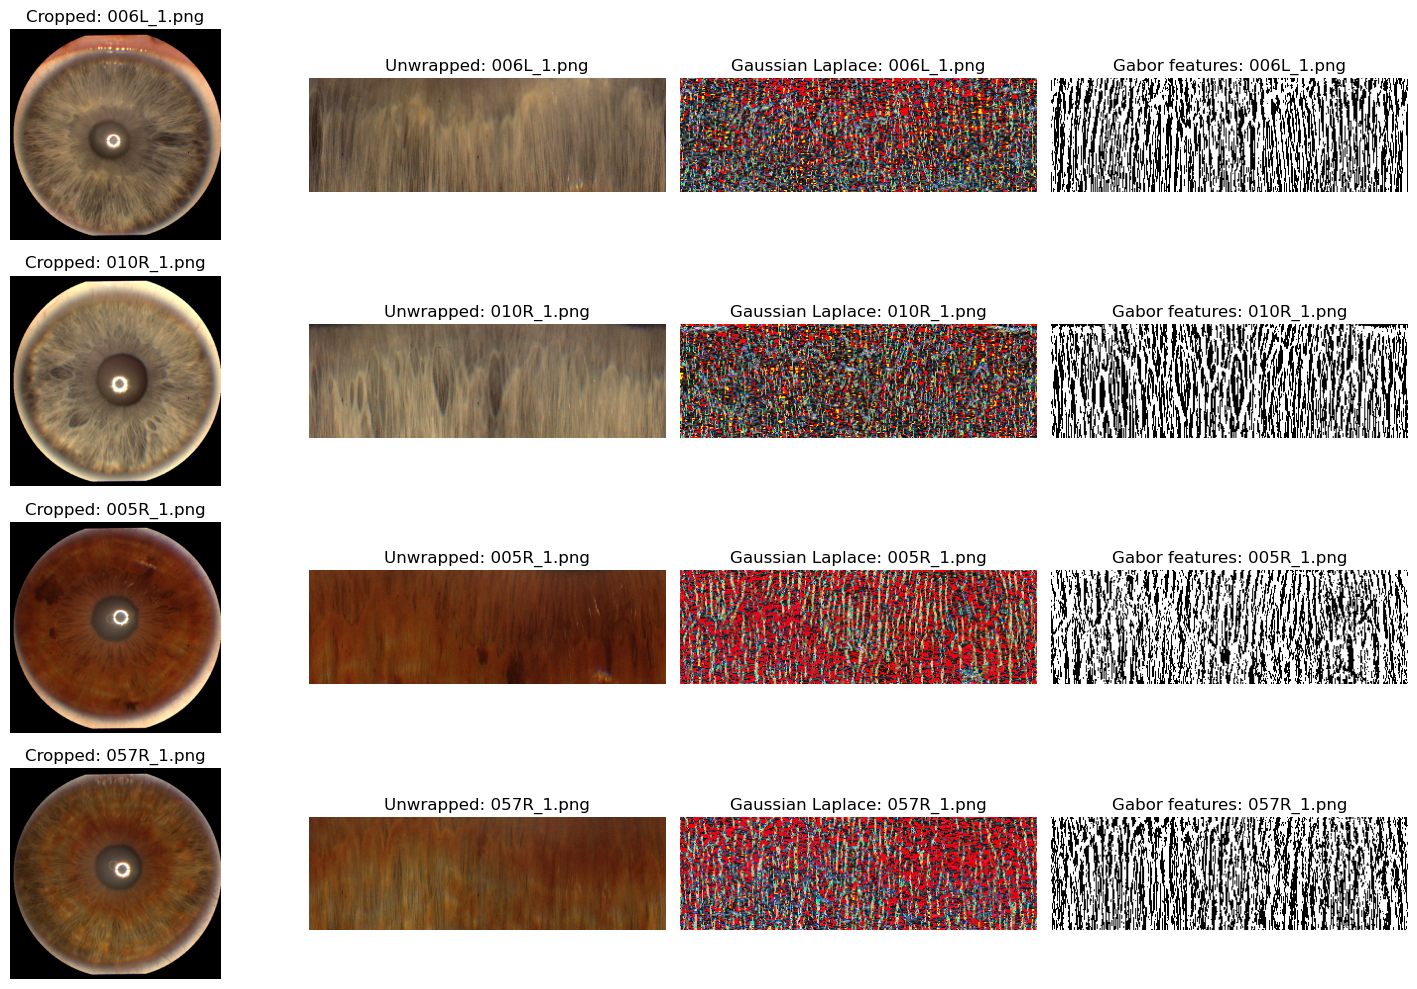

In [ ]:
# выводим результаты применения фильтров

fig, axs = plt.subplots(4, 4, figsize=(15, 10)) # создаем 8 строк по 4 столбца

for i in range(4):
    dirs_path = f'{IMAGE_TRAIN_PATH}/'
    img_file = random.choice(os.listdir(dirs_path))
    img_path = dirs_path + img_file

    # Получение обрезанного изображения, центра и радиуса
    cropped_image, center, radius = crop_circular_image(img_path)

    # "Разворачивание" обрезанного изображения
    unwrapped_image = unwrap_image(cropped_image, center, radius)

    # Применение фильтра Гаусса и оператора Лапласа
    gaussian_laplace_image = apply_gaussian_laplace(unwrapped_image)

    # Извлечение признаков с использованием вейвлетов Габора
    gabor_features = apply_gabor_filter(unwrapped_image)

    # выводим обрезанное изображение
    axs[i, 0].imshow(cropped_image)
    axs[i, 0].set_title('Cropped: ' + img_file)
    axs[i, 0].axis('off')

    # выводим развернутое изображение
    axs[i, 1].imshow(unwrapped_image)
    axs[i, 1].set_title('Unwrapped: ' + img_file)
    axs[i, 1].axis('off')

    # выводим изображение после применения фильтра Гаусса и оператора Лапласа
    axs[i, 2].imshow(gaussian_laplace_image, cmap='gray') 
    axs[i, 2].set_title('Gaussian Laplace: ' + img_file)
    axs[i, 2].axis('off')

    # выводим изображение после извлечения признаков с использованием вейвлетов Габора
    axs[i, 3].imshow(gabor_features, cmap='gray') 
    axs[i, 3].set_title('Gabor features: ' + img_file) 
    axs[i, 3].axis('off')

plt.tight_layout() # делаем более компактное расположение графиков
plt.show()

In [ ]:
# применяем функцию к тренировочной, валидационной и тестовой выборкам

processed_images_train = process_images(IMAGE_TRAIN_PATH)
print_dictionary_structure(processed_images_train)

processed_images_valid = process_images(IMAGE_VALID_PATH)
print_dictionary_structure(processed_images_valid)

processed_images_test = process_images(IMAGE_TEST_PATH)
print_dictionary_structure(processed_images_test)

100%|██████████| 128/128 [00:33<00:00,  3.87it/s]


Количество изображений: 128
Количество меток: 128
file_name: <class 'str'>
gabor_filter: <class 'numpy.ndarray'>
label: <class 'str'>
Размер изображений: (115, 360)


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]


Количество изображений: 128
Количество меток: 128
file_name: <class 'str'>
gabor_filter: <class 'numpy.ndarray'>
label: <class 'str'>
Размер изображений: (115, 360)


100%|██████████| 128/128 [00:33<00:00,  3.86it/s]

Количество изображений: 128
Количество меток: 128
file_name: <class 'str'>
gabor_filter: <class 'numpy.ndarray'>
label: <class 'str'>
Размер изображений: (115, 360)


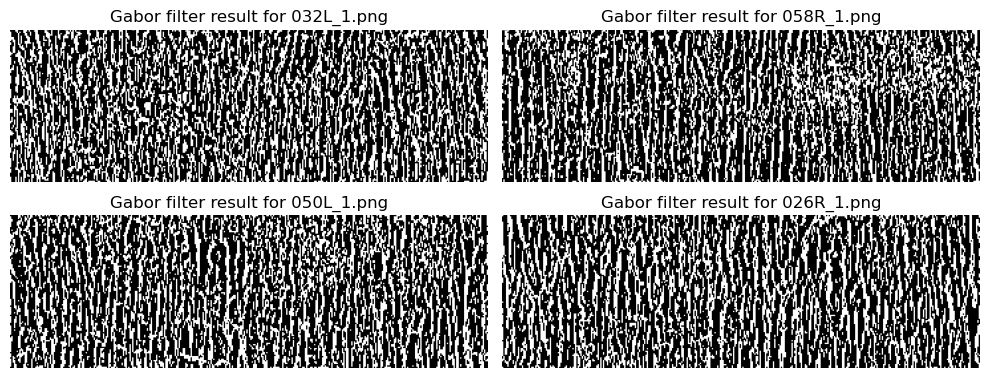

In [ ]:
# Выбираем 4 случайных результатов из списка

fig, axs = plt.subplots(2, 2, figsize=(10, 4)) # создаем 2 строки по 2 столбца

for i in range(2):
    for j in range(2):
        random_image = random.choice(processed_images_train)  # выбираем случайное изображение

        gabor_result = random_image['gabor_filter']

        axs[i, j].imshow(gabor_result, cmap='gray')
        axs[i, j].set_title('Gabor filter result for ' + random_image['file_name'])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# формируем список классов

CLASSES_TRAIN = [clss['label'] for clss in processed_images_train]
CLASSES_VALID = [clss['label'] for clss in processed_images_valid]
CLASSES_TEST = [clss['label'] for clss in processed_images_test]

print(f'Пример названий классов тренировочной выборки: {CLASSES_TRAIN[0:10]}')
print(f'Пример названий классов валидационной выборки: {CLASSES_VALID[0:10]}')
print(f'Пример названий классов тестовой выборки: {CLASSES_TEST[0:10]}')

Пример названий классов тренировочной выборки: ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Пример названий классов валидационной выборки: ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Пример названий классов тестовой выборки: ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']


In [ ]:
# создаем список классов для подмены

CLASSES_TRAIN_NEW = np.array(range(1, len(CLASSES_TRAIN)+1))
CLASSES_VALID_NEW = np.array(range(1, len(CLASSES_VALID)+1))
CLASSES_TEST_NEW = np.array(range(1, len(CLASSES_TEST)+1))

labels_train = [img['label'] for img in processed_images_train]
labels_valid = [img['label'] for img in processed_images_valid]
labels_test = [img['label'] for img in processed_images_test]

# заменяем значения меток на новые классы

labels_train_changed = np.where(np.isin(labels_train, CLASSES_TRAIN), CLASSES_TRAIN_NEW[np.searchsorted(CLASSES_TRAIN, labels_train)], labels_train)
labels_valid_changed = np.where(np.isin(labels_valid, CLASSES_VALID), CLASSES_VALID_NEW[np.searchsorted(CLASSES_VALID, labels_valid)], labels_valid)
labels_test_changed = np.where(np.isin(labels_test, CLASSES_TEST), CLASSES_TEST_NEW[np.searchsorted(CLASSES_TEST, labels_test)], labels_test)

# выводим результаты
print('Тренировочная выборка:')
print("Список классов: ", CLASSES_TRAIN[0:10])
print("Массив меток: ", labels_train[0:10])
print("Измененный массив меток: ", labels_train_changed[0:10])
print("Количество классов: ", len(CLASSES_TRAIN_NEW))

print('\nВалидационная выборка:')
print("Список классов: ", CLASSES_VALID[0:10])
print("Массив меток: ", labels_valid[0:10])
print("Измененный массив меток: ", labels_valid_changed[0:10])
print("Количество классов: ", len(CLASSES_VALID_NEW))

print('\nТестовая выборка:')
print("Список классов: ", CLASSES_TEST[0:10])
print("Массив меток: ", labels_test[0:10])
print("Измененный массив меток: ", labels_test_changed[0:10])
print("Количество классов: ", len(CLASSES_TEST_NEW))

Тренировочная выборка:
Список классов:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Массив меток:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Измененный массив меток:  ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10']
Количество классов:  128

Валидационная выборка:
Список классов:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Массив меток:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Измененный массив меток:  ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10']
Количество классов:  128

Тестовая выборка:
Список классов:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Массив меток:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Измененный массив меток:  ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10']
Количество классов:  128


### Подготовка датасета к обучению

In [ ]:
# Задаем высоту и ширину изображений

img_size =  processed_images_train[0]['gabor_filter'].shape
print(f'Входящий размер изображений: {img_size}')

IMG_HEIGHT = int(img_size[1] / 2.5)
IMG_WIDTH = int(img_size[0] / 2.5)

size = (IMG_HEIGHT, IMG_WIDTH)

print(f'Целевой размер изображений: {size}')

Входящий размер изображений: (115, 360)
Целевой размер изображений: (144, 46)


In [ ]:
# приобразуем метки в int

print('Было:', type(labels_train_changed[0]))

encoder = LabelEncoder()
labels_train_changed = encoder.fit_transform(labels_train_changed)
labels_valid_changed = encoder.fit_transform(labels_valid_changed)
labels_test_changed = encoder.fit_transform(labels_test_changed)

print('Стало:', type(labels_train_changed[0]))

Было: <class 'numpy.str_'>
Стало: <class 'numpy.int64'>


In [ ]:
# Пустой список для изображений тренировочной выборки
data_images = []

for img in tq.tqdm(processed_images_train):
    # Извлекаем обработанное изображение и изменяем его размер
    img_np = cv2.resize(img['gabor_filter'], (IMG_HEIGHT, IMG_WIDTH)) # 1 место
    data_images.append(img_np)

# Перевод общего списка изображений в PyTorch-тензор
# Используется np.transpose для смены порядка размерностей на (N, H, W)
x_train_data = torch.from_numpy(np.array(data_images)[..., np.newaxis].transpose((0, 3, 1, 2))) # место

# Перевод общего списка меток класса в PyTorch-тензор
y_train_data = torch.tensor(labels_train_changed)

print(f'В массив собрано {len(data_images)} изображений следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_train_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_train_data.shape}')

100%|██████████| 128/128 [00:00<00:00, 25594.53it/s]

В массив собрано 128 изображений следующей формы: (46, 144)
Общий массив данных изображений следующей формы: torch.Size([128, 1, 46, 144])
Общий массив меток классов следующей формы: torch.Size([128])


In [ ]:
# Пустой список для изображений валидационной выборки
data_images = []

for img in tq.tqdm(processed_images_valid):
    # Извлекаем обработанное изображение и изменяем его размер
    img_np = cv2.resize(img['gabor_filter'], (IMG_HEIGHT, IMG_WIDTH)) # 1 место
    data_images.append(img_np)

# Перевод общего списка изображений в PyTorch-тензор
# Используется np.transpose для смены порядка размерностей на (N, H, W)
x_valid_data = torch.from_numpy(np.array(data_images)[..., np.newaxis].transpose((0, 3, 1, 2))) # место

# Перевод общего списка меток класса в PyTorch-тензор
y_valid_data = torch.tensor(labels_valid_changed)

print(f'В массив собрано {len(data_images)} изображений следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_valid_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_valid_data.shape}')

100%|██████████| 128/128 [00:00<00:00, 30799.78it/s]

В массив собрано 128 изображений следующей формы: (46, 144)
Общий массив данных изображений следующей формы: torch.Size([128, 1, 46, 144])
Общий массив меток классов следующей формы: torch.Size([128])


In [ ]:
# Пустой список для изображений тестовой выборки
data_images = []

for img in tq.tqdm(processed_images_test):
    # Извлекаем обработанное изображение и изменяем его размер
    img_np = cv2.resize(img['gabor_filter'], (IMG_HEIGHT, IMG_WIDTH)) # 1 место
    data_images.append(img_np)

# Перевод общего списка изображений в PyTorch-тензор
# Используется np.transpose для смены порядка размерностей на (N, H, W)
x_test_data = torch.from_numpy(np.array(data_images)[..., np.newaxis].transpose((0, 3, 1, 2))) # место

# Перевод общего списка меток класса в PyTorch-тензор
y_test_data = torch.tensor(labels_valid_changed)

print(f'В массив собрано {len(data_images)} изображений следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_test_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_test_data.shape}')

100%|██████████| 128/128 [00:00<00:00, 29781.49it/s]

В массив собрано 128 изображений следующей формы: (46, 144)
Общий массив данных изображений следующей формы: torch.Size([128, 1, 46, 144])
Общий массив меток классов следующей формы: torch.Size([128])


#### Сборка архитектуры модели и аугментация

In [ ]:
# Определяем модель
class ImageClassifier(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 11 * 36, 256),
            nn.ReLU(),
            nn.Linear(256, 129),
        )
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.nll_loss(outputs, targets)
        preds = torch.argmax(outputs, dim=1) 
        acc = torch.sum(preds == targets.data) / (targets.shape[0] * 1.0)  # Вычисляем accuracy
        self.log('train_loss', loss)
        self.log('train_acc', acc)  # Логируем accuracy
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.nll_loss(outputs, targets)
        preds = torch.argmax(outputs, dim=1)
        acc = torch.sum(preds == targets.data) / (targets.shape[0] * 1.0)  # Вычисляем accuracy
        self.log('val_loss', loss)
        self.log('val_acc', acc)  # Логируем accuracy
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
# Создаем экземпляр модели
model = ImageClassifier()

# Определяем преобразования для аугментации данных
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
#    transforms.RandomRotation(10),
#    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# подготавливаем данные

batch_size = 16

train_data = [(train_transforms(image), label) for image, label in zip(x_train_data, y_train_data)]
val_data = [(val_transforms(image), label) for image, label in zip(x_valid_data, y_valid_data)]

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=20)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=20)
test_loader = DataLoader((x_test_data, y_test_data), batch_size=batch_size, num_workers=20)

In [ ]:
# cмотрим на параметры слоев в модели

#for p in model.parameters():
#    print(p.shape)

In [ ]:
# создадим функцию расчета accuracy

def evaluate_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
# cмотрим на параметры слоев в модели

def print_shape(module, input_tensor, output_tensor):
    print(f'{module}')
    print(f'{input_tensor[0].shape} -> {output_tensor.shape}\n')

model = ImageClassifier()
    
hooks = []
for module in model.model:  # Здесь мы итерируемся по модулям внутри nn.Sequential
    hooks.append(module.register_forward_hook(print_shape))

output_features = model(x_train_data.float())

for hook in hooks:
    hook.remove()

Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([128, 1, 46, 144]) -> torch.Size([128, 128, 46, 144])

ReLU()
torch.Size([128, 128, 46, 144]) -> torch.Size([128, 128, 46, 144])

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([128, 128, 46, 144]) -> torch.Size([128, 128, 23, 72])

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([128, 128, 23, 72]) -> torch.Size([128, 128, 23, 72])

ReLU()
torch.Size([128, 128, 23, 72]) -> torch.Size([128, 128, 23, 72])

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([128, 128, 23, 72]) -> torch.Size([128, 128, 11, 36])

Flatten(start_dim=1, end_dim=-1)
torch.Size([128, 128, 11, 36]) -> torch.Size([128, 50688])

Linear(in_features=50688, out_features=256, bias=True)
torch.Size([128, 50688]) -> torch.Size([128, 256])

ReLU()
torch.Size([128, 256]) -> torch.Size([128, 256])

Linear(in_features=256, out_features=129, bias

In [ ]:
# Подготавливаем контрольную точку
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
#    dirpath='/checkpoints',
    filename='model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

In [ ]:
# Инициализируем тренера и запускаем обучение
trainer = Trainer(max_epochs=20, accelerator='mps', #callbacks=[checkpoint_callback]
                 )
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 13.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
13.2 M    Trainable params
0         Non-trainable params
13.2 M    Total params
52.634    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 8/8 [00:03<00:00,  2.66it/s, v_num=16]           
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s, v_num=16]      
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 8/8 [00:03<00:00,  2.62it/s, v_num=16]      
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s, v_num=16]      
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s, v_num=16]      
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, v_num=16]      
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s, v_num=16]      
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s, v_num=16]      
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s, v_num=16]      
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s, v_num=16]      
Valida

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s, v_num=16]


In [ ]:
trainer.logged_metrics

{'train_loss': tensor(-23404692.),
 'train_acc': tensor(0.),
 'val_loss': tensor(-25010414.),
 'val_acc': tensor(0.0078)}

In [ ]:
# переводим модель в режим оценки

model.eval()

ImageClassifier(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=50688, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=129, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)

### Проверка адекватности распознавания изображений моделью

In [ ]:
x = x_train[0].reshape(1, input_shape[0],input_shape[1],1)

In [ ]:
model.layers

In [ ]:
# проверяем форму выхода первого сверточного слоя

first_conv_output = model.layers[0](x)
first_conv_output.shape

In [ ]:
# проверяем результат работы первого сверточного слоя

plt.figure(figsize=(20, 10))

for i in range(32):
  plt.subplot(4, 8, i + 1)
  plt.imshow(first_conv_output[0, : , : , i], cmap='gray')
  plt.axis('off')
plt.show()

In [ ]:
# подаем результат первого сверточного слоя во второй сверточный слой

second_conv_output = model.layers[2](first_conv_output)
second_conv_output.shape

In [ ]:
# проверяем результат работы второго сверточного слоя

plt.figure(figsize=(20, 10))

for i in range(32):
  plt.subplot(4, 8, i + 1)
  plt.imshow(second_conv_output[0, : , : , i], cmap='gray')
  plt.axis('off')
plt.show()